Group : SE1

DEJEAN Maxime
COCOMA David


## Advice
### Work
- **Read the whole subject before starting**
- Search for the documentation (Google) before asking a teacher
- The work will be evaluated based on this notebook:
    - Answer questions in the notebook.
    - Insert your code here and execute it so that the output stays displayed for the teacher.
- The slides of the lecture contain most of the answers for this lab...

### ChatGPT
- You can use ChatGPT ONLY to answer specific questions, get introductory explanations on machine learning libraries, get example codes. Be aware that there is no guaranty in the answer of ChatGPT (even with the paying licence).
- Do not use ChatGPT to work in your stead ! The goal is for you to learn the manipulation of machine learning basic methods yourself. Teachers are used to look at student's works and ChatGPT is not good to fake it.
=> In case of a doubt of ChatGPT use (or plagiarism between groups), the students will be summoned and evaluated on an oral presentation.

## Objectives of the practical work

The objective is to get hands on experience on the fundamental elements of neural networks:
 
 - perceptron architecture (linear regression)
 - loss function
 - empirical loss
 - gradient descent

For this we will implement from scratch the data-structure and algorithms to train a perceptron. Note that slides related to the perceptron and neural networks in general are available on [moodle](https://moodle.insa-toulouse.fr/course/view.php?id=1790).

## Dataset

The objective of the regression is the prediction of the hydrodynamic performance of sailing yachts from dimensions and velocity.
The **inputs** are linked to dimension and hydrodynamics characteristics:
1. Longitudinal position of the center of buoyancy
(*flottabilité*), adimensional.
2. Prismatic coefficient, adimensional.
3. Length-displacement ratio, adimensional.
4. Beam -draught ratio ((*tiran d’eau*), adimensional.
5. Length-beam ratio, adimensional.
6. Froude number, adimensional

**Target value/predicted value (Output)** = Residuary resistance per unit weight of
displacement, adimensional

In [81]:
# Import some useful libraries and functions
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def print_stats(dataset):
    """Print statistics of a dataset"""
    print(pd.DataFrame(dataset).describe())


In [82]:
# Download the data set and place in the current folder (works on linux only)
filename = 'yacht_hydrodynamics.data'

import os.path
import requests

if not os.path.exists(filename):
    print("Downloading dataset...")
    r = requests.get('https://arbimo.github.io/tp-supervised-learning/2223-ae/tp1/' + filename)
    open(filename , 'wb').write(r.content)
    
print('Dataset available')


Dataset available


### Explore the dataset

- how many examples are there in the dataset?
There are 308 examples
- how many features for each example?
There are 7 features 
- what is the ground truth of the 10th example
1.83

In [83]:
# load the dataset and slip between inputs (X) and ground truth (Y)
dataset = np.genfromtxt("yacht_hydrodynamics.data", delimiter='')
X = dataset[:, :-1] # examples features -  all rows with all elements in rows except last one
Y = dataset[:, -1]  # ground truth - last element in all rows

# Print the first 5 examples
for i in range(0,5):
    print(f"f({X[i]}) = {Y[i]}")

df=pd.DataFrame(dataset)
print(df)

print(Y[9],"is the 10th ground element")

f([-5.    0.6   4.78  4.24  3.15  0.35]) = 8.62
f([-5.     0.565  4.77   3.99   3.15   0.15 ]) = 0.18
f([-2.3    0.565  4.78   5.35   2.76   0.15 ]) = 0.29
f([-5.     0.6    4.78   4.24   3.15   0.325]) = 6.2
f([0.    0.53  4.78  3.75  3.15  0.175]) = 0.59
       0      1     2     3     4      5     6
0   -5.0  0.600  4.78  4.24  3.15  0.350  8.62
1   -5.0  0.565  4.77  3.99  3.15  0.150  0.18
2   -2.3  0.565  4.78  5.35  2.76  0.150  0.29
3   -5.0  0.600  4.78  4.24  3.15  0.325  6.20
4    0.0  0.530  4.78  3.75  3.15  0.175  0.59
..   ...    ...   ...   ...   ...    ...   ...
303 -2.4  0.568  4.34  2.98  3.15  0.350  6.86
304 -2.3  0.564  5.10  3.95  3.53  0.175  0.65
305 -2.3  0.530  4.76  3.68  3.16  0.200  0.76
306 -5.0  0.600  4.78  4.24  3.15  0.275  2.84
307 -2.3  0.530  5.11  3.69  3.51  0.350  7.84

[308 rows x 7 columns]
1.83 is the 10th ground element


The following command adds a column to the inputs.

- what is the value added this column?
it's a column of ones 
- why are we doing this?
to add the bias as a weight to compute it easily

In [84]:
X = np.insert(X, 0, np.ones((len(X))), axis= 1)
print_stats(X)


           0           1           2           3           4           5  \
count  308.0  308.000000  308.000000  308.000000  308.000000  308.000000   
mean     1.0   -2.381818    0.564136    4.788636    3.936818    3.206818   
std      0.0    1.513219    0.023290    0.253057    0.548193    0.247998   
min      1.0   -5.000000    0.530000    4.340000    2.810000    2.730000   
25%      1.0   -2.400000    0.546000    4.770000    3.750000    3.150000   
50%      1.0   -2.300000    0.565000    4.780000    3.955000    3.150000   
75%      1.0   -2.300000    0.574000    5.100000    4.170000    3.510000   
max      1.0    0.000000    0.600000    5.140000    5.350000    3.640000   

                6  
count  308.000000  
mean     0.287500  
std      0.100942  
min      0.125000  
25%      0.200000  
50%      0.287500  
75%      0.375000  
max      0.450000  


## Creating the perceptron

![Perceptron for regression](https://arbimo.github.io/tp-supervised-learning/2223-ae/tp1/perceptron-regression.png)

We now want to define a perceptron, that is, a function of the form: 

$h_w(x) = w_0 + w_1 \times x_1 + \dots + w_n \times x_n$

- Complete the code snippet below to:
  - create the vector of weight `w`, initialize to arbitrary values (we suggest 0)
  - implement the `h` function that evaluate an example based on the vector of weights
  - check if this works on a few examples

In [124]:
w = np.zeros(X.shape[1]) # we create a weigth vector of the features size in 0
#w = np.random.randn(X.shape[1]) * 0.01 #try to initialise our weights close to 0 to see if it influences our predictions
print(w)
print(X[0,:])

def h(w, x):
    return np.dot(w,x)

h0 = h(w,X[0,:])
#print(h0)

print("Calculated value: ",h0)
# print the ground truth and the evaluation of h_w on the first example
print("Real value: ",Y[0])

[0. 0. 0. 0. 0. 0. 0.]
[ 1.   -5.    0.6   4.78  4.24  3.15  0.35]
Calculated value:  0.0
Real value:  8.62


## Loss function

Complete the definiton of the loss function below such that, for a **single** example `x` with ground truth `y`, it returns the $L_2$ loss of $h_w$ on `x`.

In [125]:

def loss(w,x,y):
    out=(h(w,x)-y)**2
    return out

L = loss(w,X[0,:],Y[0])
print("loss=",L)


loss= 74.30439999999999


## Empirical loss

Complete the function below to compute the empirical loss of $h_w$ on a **set** of examples $X$ with associated ground truths $Y$.

In [126]:
def emp_loss(w, X, Y):
    sum = 0
    for i in range (0,len(X)):
        x = X[i]
        y = Y[i]
        sum += (loss(w,x,y))/len(X)
    return sum

empl = emp_loss(w,X,Y)
print("emploss=",empl)

emploss= 339.24674642857144


## Gradient update

A gradient update is of the form: $w \gets w + dw$

- Complete the function below so that it computes the $dw$ term (the 'update') based on a set of examples `(X, Y)` the step (`alpha`)

(you can look at slide 32 of the ANN lecture slides for an example)

In [127]:

def compute_update(w, X, Y, alpha):
    
    new = np.zeros(len(w))
    
    for i in range(len(w)):
        S = 0
        for j in range(len(X)):
            x = X[j, :]
            y = Y[j]
            S += (y - h(w, x)) * x[i]
        
        new[i] = w[i] - alpha * (-S / len(X))
    
    return new

## Gradient descent

Now implement the gradient descent algorithm that will:

- repeatedly apply an update the weights 
- stops when a max number of iterations is reached (do not consider early stopping for now)
- returns the final vector of weights

In [128]:
def descent(w_init, X, Y, alpha, max_iter):
    w = w_init.copy() #we use copy() so we won't modify the initialised weights
    for i in range (0,max_iter):
        print(f"{i}, weights={w}") #we verify that the weights are updating and converge towards a value
        w = compute_update(w, X, Y, alpha)
    return w
    
new = descent(w, X, Y, 10e-4, 1000)
#we can try different pace of learning rate to try to debug the predictions (see last graph)
#alpha=10^-4 seems enough to let all the weights converge
print(w)
print(new)


0, weights=[0. 0. 0. 0. 0. 0. 0.]
1, weights=[ 0.01049536 -0.02455656  0.00591076  0.0502471   0.04121542  0.03365286
  0.0042531 ]
2, weights=[ 0.02040638 -0.04766531  0.01149171  0.09768924  0.08011723  0.06542977
  0.00833816]
3, weights=[ 0.0297659  -0.06940772  0.01676139  0.14248398  0.11683538  0.09543612
  0.01226463]
4, weights=[ 0.03860488 -0.0898607   0.02173728  0.18478002  0.15149255  0.12377135
  0.0160414 ]
5, weights=[ 0.04695257 -0.10909683  0.02643588  0.22471772  0.18420449  0.15052933
  0.01967688]
6, weights=[ 0.05483656 -0.12718462  0.03087277  0.26242954  0.21508046  0.17579865
  0.02317901]
7, weights=[ 0.06228291 -0.14418872  0.03506264  0.2980405   0.2442236   0.19966294
  0.02655529]
8, weights=[ 0.06931618 -0.16017017  0.03901938  0.33166861  0.27173123  0.22220109
  0.02981277]
9, weights=[ 0.07595959 -0.17518654  0.04275607  0.36342524  0.29769521  0.24348761
  0.03295813]
10, weights=[ 0.08223502 -0.1892922   0.04628507  0.39341549  0.32220224  0.26359278

## Exploitation

You gradient descent is now complete and you can exploit it to train your perceptron.

- Train your perceptron to get a model.
- Visualize the evolution of the loss on the training set. Has it converged?
- Try training for several choices of `alpha` and `max_iter`. What seem like a reasonable choice? Plot the loss depending on the parameter values (and optionnaly the evolution of the loss)
- What is the loss associated with the final model?
- Is the final model the optimal one for a perceptron?

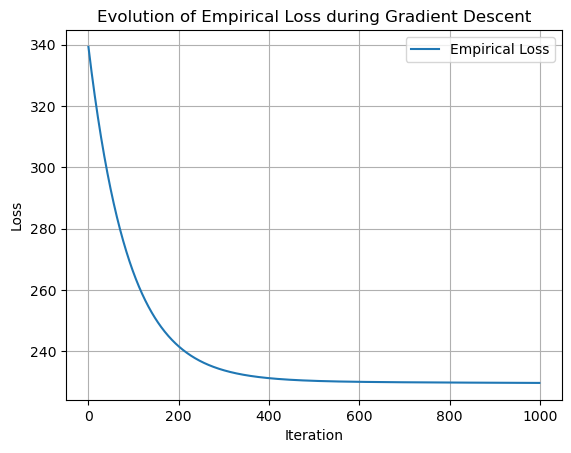

In [129]:
# TODO
def plotw(w_init, X, Y, alpha, max_iter):
    w = w_init.copy()
    loss_history = []
    for i in range (0,max_iter):
        loss_value = emp_loss(w, X, Y)        
        loss_history.append(loss_value)
        w = compute_update(w, X, Y, alpha)

    plt.plot(range(max_iter), loss_history, label="Empirical Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Evolution of Empirical Loss during Gradient Descent")
    plt.legend()
    plt.grid(True)
    plt.show()
    return w

final_weights = plotw(w_init, X, Y, 10e-5, 1000)


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
C:\Users\User\AppData\Local\Temp\ipykernel_26096\2388930886.py:6: SyntaxWarning: invalid escape sequence '\h'
  plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')


Text(0, 0.5, 'f(examples)')

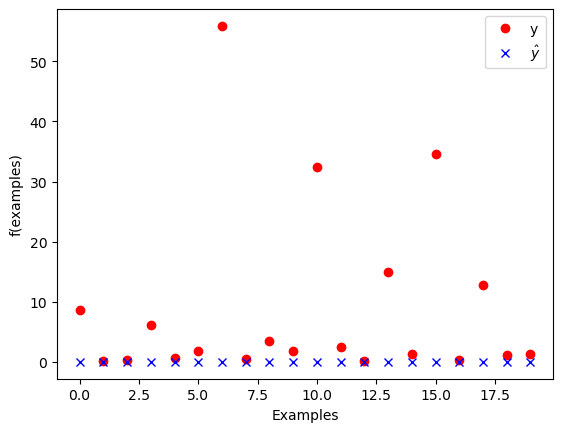

In [130]:
# Code sample that can be used to visualize the difference between the ground truth and the prediction

num_samples_to_plot = 20
plt.plot(Y[0:num_samples_to_plot], 'ro', label='y')
yw = [h(w,x) for x in X]
plt.plot(yw[0:num_samples_to_plot], 'bx', label='$\hat{y}$')
plt.legend()
plt.xlabel("Examples")
plt.ylabel("f(examples)")

#I can't find why our predictions are this close to 0... Might be that our model doesn't learn effectively ?





# Going further

The following are extensions of the work previously done. If attempting them **do not modify** the code you produced above so that it can be evaluated.

### Improvements to gradient descent

Consider improving the gradient descent with:

 - Stochastic Gradient Descent (SGD), which means selecting a subset of the examples for training
 - Detection of convergence to halt the algorithm before the maximum number of iterations


### Data normalization

Different input features can have different units, and very different ranges.
Within the perceptron computation, these values will be summed together.
While gradient descent is normally able to deal with this (by adapting the weights of the perceptron for each input feature), standardizing the input features usually eases the perceptron training, and can sometimes improve accuracy.




```python
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True) 
X_normalized = sc.fit_transform(X)
```

Try applying a standard normalization to the input features (make sure that you keep a feature column that is always equal to 1). Is the convergence faster ? Try to quantify this speed-up. What about accuracy ?